# Design single unit perceptron for classification of iris dataset without using pre-defined models.  

References: 

https://pub.towardsai.net/nothing-but-numpy-understanding-creating-neural-networks-with-computational-graphs-from-scratch-6299901091b0 
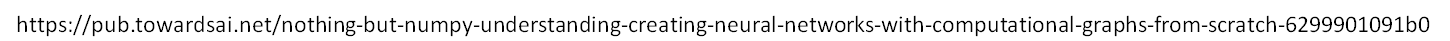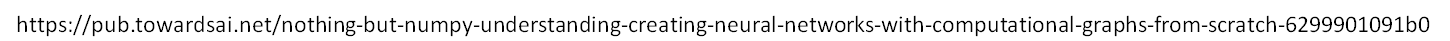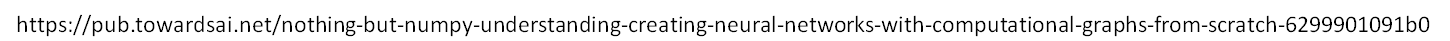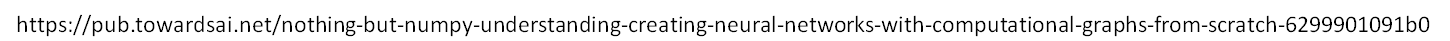
https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c 
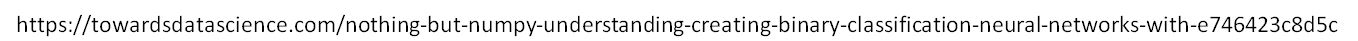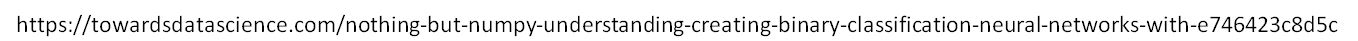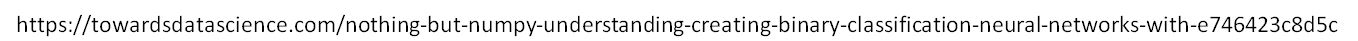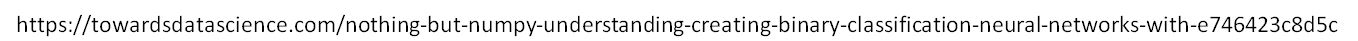

In [1]:
#Importing required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
#Read Dataset into dataframe and preprocess

data = pd.read_csv('/kaggle/input/iris/Iris.csv')
#Convert target from object to category
data.Species = data.Species.astype('category')
data['iris_cat']=data.Species.cat.codes

data=data[data.iris_cat<2]
data.shape

(100, 7)

In [3]:
# Splitting Dataset into train and test

from sklearn.model_selection import train_test_split
data1=data[['PetalLengthCm', 'PetalWidthCm','SepalLengthCm','SepalWidthCm', 'iris_cat']]
print(data1.head())
x_train, x_test, y_train, y_test = train_test_split(data1[['PetalLengthCm', 'PetalWidthCm']],data1['iris_cat'], test_size=0.3,shuffle=True)

X_train = np.array(x_train.T)
Y_train = np.array(y_train).reshape(1,-1) 
X_train.shape,Y_train.shape
Y_train

   PetalLengthCm  PetalWidthCm  SepalLengthCm  SepalWidthCm  iris_cat
0            1.4           0.2            5.1           3.5         0
1            1.4           0.2            4.9           3.0         0
2            1.3           0.2            4.7           3.2         0
3            1.5           0.2            4.6           3.1         0
4            1.4           0.2            5.0           3.6         0


array([[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0]], dtype=int8)

In [4]:
#Define required methods for Artificial Neural Networks
def initialize_parameters(n_in, n_out, ini_type='plain'):
    """
    Helper function to initialize some form of random weights and Zero biases
    Args:
        n_in: size of input layer
        n_out: size of output/number of neurons
        ini_type: set initialization type for weights
    Returns:
        params: a dictionary containing W and b
    """

    params = dict()  # initialize empty dictionary of neural net parameters W and b

    params['W'] = np.random.randn(n_out, n_in) *0.01  # set weights 'W' to small random gaussian
    params['b'] = np.zeros((n_out, 1))    # set bias 'b' to zeros

    return params

In [5]:
class LinearLayer:
    """
        This Class implements all functions to be executed by a linear layer
        in a computational graph
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
                      Opitons are: plain, xavier and he
        Methods:
            forward(A_prev)
            backward(upstream_grad)
            update_params(learning_rate)
    """

    def __init__(self, input_shape, n_out, ini_type="plain"):
        """
        The constructor of the LinearLayer takes the following parameters
        Args:
            input_shape: input shape of Data/Activations
            n_out: number of neurons in layer
            ini_type: initialization type for weight parameters, default is "plain"
        """

        self.m = input_shape[1]  # number of examples in training data
        # `params` store weights and bias in a python dictionary
        self.params = initialize_parameters(input_shape[0], n_out, ini_type)  # initialize weights and bias
        self.Z = np.zeros((self.params['W'].shape[0], input_shape[1]))  # create space for resultant Z output

    def forward(self, A_prev):
        """
        This function performs the forwards propagation using activations from previous layer
        Args:
            A_prev:  Activations/Input Data coming into the layer from previous layer
        """

        self.A_prev = A_prev  # store the Activations/Training Data coming in
        self.Z = np.dot(self.params['W'], self.A_prev) + self.params['b']  # compute the linear function

    def backward(self, upstream_grad):
        """
        This function performs the back propagation using upstream gradients
        Args:
            upstream_grad: gradient coming in from the upper layer to couple with local gradient
        """

        # derivative of Cost w.r.t W
        self.dW = np.dot(upstream_grad, self.A_prev.T)

        # derivative of Cost w.r.t b, sum across rows
        self.db = np.sum(upstream_grad, axis=1, keepdims=True)

        # derivative of Cost w.r.t A_prev
        self.dA_prev = np.dot(self.params['W'].T, upstream_grad)

    def update_params(self, learning_rate=0.1):
        """
        This function performs the gradient descent update
        Args:
            learning_rate: learning rate hyper-param for gradient descent, default 0.1
        """

        self.params['W'] = self.params['W'] - learning_rate * self.dW  # update weights
        self.params['b'] = self.params['b'] - learning_rate * self.db  # update bias(es)

In [6]:
class SigmoidLayer:
    """
    This file implements activation layers
    inline with a computational graph model
    Args:
        shape: shape of input to the layer
    Methods:
        forward(Z)
        backward(upstream_grad)
    """

    def __init__(self, shape):
        """
        The consturctor of the sigmoid/logistic activation layer takes in the following arguments
        Args:
            shape: shape of input to the layer
        """
        self.A = np.zeros(shape)  # create space for the resultant activations

    def forward(self, Z):
        """
        This function performs the forwards propagation step through the activation function
        Args:
            Z: input from previous (linear) layer
        """
        self.A = 1 / (1 + np.exp(-Z))  # compute activations

    def backward(self, upstream_grad):
        """
        This function performs the  back propagation step through the activation function
        Local gradient => derivative of sigmoid => A*(1-A)
        Args:
            upstream_grad: gradient coming into this layer from the layer above
        """
        # couple upstream gradient with local gradient, the result will be sent back to the Linear layer
        self.dZ = upstream_grad * self.A*(1-self.A)

In [7]:
import numpy as np

"""
Contains a bunch of Cost functions.
This file implementations of :
    - Binary Cross_entropy Cost function
        * compute_binary_cost(Y, P_hat) -> "unstable"
        * compute_stable_bce_cost(Y, Z) -> "stable" 
        * computer_keras_like_bce_cost(Y, P_hat, from_logits=False) -> stable
    - Mean Squared Error Cost function
"""


def compute_bce_cost(Y, P_hat):
    """
    This function computes Binary Cross-Entropy(bce) Cost and returns the Cost and its
    derivative.
    This function uses the following Binary Cross-Entropy Cost defined as:
    => (1/m) * np.sum(-Y*np.log(P_hat) - (1-Y)*np.log(1-P_hat))
    Args:
        Y: labels of data
        P_hat: Estimated output probabilities from the last layer, the output layer
    Returns:
        cost: The Binary Cross-Entropy Cost result
        dP_hat: gradient of Cost w.r.t P_hat
    """
    m = Y.shape[1]  # m -> number of examples in the batch

    cost = (1/m) * np.sum(-Y*np.log(P_hat) - (1-Y)*np.log(1-P_hat))
    cost = np.squeeze(cost)  # remove extraneous dimensions to give just a scalar (e.g. this turns [[17]] into 17)

    dP_hat = (1/m) * (-(Y/P_hat) + ((1-Y)/(1-P_hat)))

    return cost, dP_hat

def compute_stable_bce_cost(Y, Z):
    """
    This function computes the "Stable" Binary Cross-Entropy(stable_bce) Cost and returns the Cost and its
    derivative w.r.t Z_last(the last linear node) .
    The Stable Binary Cross-Entropy Cost is defined as:
    => (1/m) * np.sum(max(Z,0) - ZY + log(1+exp(-|Z|)))
    Args:
        Y: labels of data
        Z: Values from the last linear node
    Returns:
        cost: The "Stable" Binary Cross-Entropy Cost result
        dZ_last: gradient of Cost w.r.t Z_last
    """
    m = Y.shape[1]

    cost = (1/m) * np.sum(np.maximum(Z, 0) - Z*Y + np.log(1+ np.exp(- np.abs(Z))))
    dZ_last = (1/m) * ((1/(1+np.exp(- Z))) - Y)  # from Z computes the Sigmoid so P_hat - Y, where P_hat = sigma(Z)

    return cost, dZ_last



In [8]:
Y_train.shape

(1, 70)

In [9]:
X_train.shape

(2, 70)

1 hidden layer

In [10]:
# define training constants
learning_rate = 1
number_of_epochs = 10000

np.random.seed(48) # set seed value so that the results are reproduceable
                   # (weights will now be initailzaed to the same pseudo-random numbers, each time)

# Our network architecture has the shape: 
#                       (input)--> [Linear->Sigmoid] -->(output)  


#------ LAYER-1 ----- define output layer that takes in training data 
Z1 = LinearLayer(input_shape=X_train.shape, n_out=4, ini_type='plain')
A1 = SigmoidLayer(Z1.Z.shape)
Z2 = LinearLayer(input_shape=A1.A.shape, n_out=1, ini_type='plain')
A2 = SigmoidLayer(Z2.Z.shape)

In [11]:
costs = []  # initially empty list, this will store all the costs after a certain number of epochs

# Start training
for epoch in range(number_of_epochs): #number_of_epochs):

    # ------------------------- forward-prop -------------------------
    Z1.forward(X_train)
    A1.forward(Z1.Z)
    Z2.forward(A1.A)
    A2.forward(Z2.Z)
    # ---------------------- Compute Cost ----------------------------
    #cost, dZ2 = compute_stable_bce_cost(Y_train, Z2.Z)
    #cost, dA2 = compute_stable_bce_cost(Y_train, A2.A)
    cost, dA2 = compute_stable_bce_cost(Y_train, A2.A)

    # print and store Costs every 100 iterations and of the last iteration.
    if (epoch % 100) == 0 or epoch == number_of_epochs - 1:
        print("Cost at epoch#{}: {}".format(epoch, cost))
        costs.append(cost)    

    # ------------------------- back-prop ----------------------------        
    A2.backward(dA2)
    Z2.backward(A2.dZ)
    A1.backward(Z2.dA_prev)
    Z1.backward(A1.dZ)
    
    # ----------------------- Update weights and bias ----------------
    Z2.update_params(learning_rate=learning_rate)
    Z1.update_params(learning_rate=learning_rate)

Cost at epoch#0: 0.7460442604486274
Cost at epoch#100: 0.6724123008531236
Cost at epoch#200: 0.6189010680820853
Cost at epoch#300: 0.565020581945594
Cost at epoch#400: 0.543299973630763
Cost at epoch#500: 0.5345062122699957
Cost at epoch#600: 0.530147949779734
Cost at epoch#700: 0.5276347995283116
Cost at epoch#800: 0.5260278362918078
Cost at epoch#900: 0.5249228141359699
Cost at epoch#1000: 0.5241213594167418
Cost at epoch#1100: 0.5235160583883346
Cost at epoch#1200: 0.5230441793424712
Cost at epoch#1300: 0.5226668356670984
Cost at epoch#1400: 0.5223587359725175
Cost at epoch#1500: 0.5221027689714796
Cost at epoch#1600: 0.521886969837485
Cost at epoch#1700: 0.5217027354576789
Cost at epoch#1800: 0.5215437300168
Cost at epoch#1900: 0.5214051896408218
Cost at epoch#2000: 0.521283466792744
Cost at epoch#2100: 0.5211757236214553
Cost at epoch#2200: 0.5210797206153015
Cost at epoch#2300: 0.5209936678420715
Cost at epoch#2400: 0.5209161182529798
Cost at epoch#2500: 0.5208458898509553
Cost a

In [12]:
#Predict the labels for test dataset 
X_test = np.array(x_test.T)
Y_test = np.array(y_test).reshape(1,-1) 
X_test.shape,Y_test.shape

Z1.forward(X_test)
A1.forward(Z1.Z)
Z2.forward(A1.A)
A2.forward(Z2.Z)
predictions=A2.A.round()
#predictions.dtype='int32'

In [13]:
#original values of test dataset
Y_test

array([[1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1]], dtype=int8)

In [14]:
predictions

array([[1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1.]])

In [15]:
compute_stable_bce_cost(Y_test,predictions )[0]

0.4652158847349118